## Use GLM to Predict Change in Cases

We are interested in using the existing cases and other information to predict the upcoming change in cases. 

We use H2O implementation to perform Linear Regression on the time series data. In this setup, we attempt to use first $n$ days of data to predict the 3-day change in the number of cases following the training period, i.e. change in case from day $n$ to day $n+3$.

The training data includes:

- Weather information
- Population
- Mobility
- Number of cases and deaths in the training period

Training data is on the county level with the first $n$ days of data averaged to create the observation by county. We found 7-day training data, i.e. $n=7$, to be the most appropriate amount of training data used for prediction the change in the number of cases in the following 3 days. 

Instead of creating one large regression that attempts to capture all data points, we create rolling 7-day periods for each county. The first period starts the first day with more than 10 cases in the county. Then we train separate models for each one of the rolling periods: one using data from day 0 to day 7 to predict increase in cases to day 10; another using data from day 1 to day 8 to predict cases to day 11; and so on.
Therefore, in the GLM results, we present the coefficient estimates along with the group of `start dates` used in the training data.

In [1]:
import sys
sys.path.append('../.')

import datetime
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

# custom libraries are used to make training easier
from lib import get_data
from lib import simplified_model

rc('text', usetex=False)

../lib
Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,4 days 3 hours 46 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,1 month and 20 days
H2O cluster name:,H2O_from_python_tcai_1f2d4e
H2O cluster total nodes:,1
H2O cluster free memory:,15.85 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


In [2]:
def prepare_model_data(date_range, pred_day, outcome):
    """
    Instead of creating a single regression that attempts to capture all observations across the entire time horizon, we
    create rolling 7-day periods for each county, with the first period starting on the first day with more than 10
    cases in a given county. We then train separate models for each rolling period: the first model is trained with data
    from Day 1 to Day 7 to predict increase in cases from Day 7 to Day 10: the second model is trained with data from Day
    2 to Day 8 to predict the change leading up to Day 11; and so on. This is easily illustrated in our results in the
    methodology section. For instance, you will find in the coefficient plots for Generalized Linear Model that a total
    of around twenty coefficient data points are plotted for each coefficient – this is because we fit 20 separate models
    based on data set with different training start days (may be referred to as “start day” in other parts of this report).

    :param date_range: range of dates used for prediction
    :param pred_day: the last of the n-day prediction period used for prediction
    :param outcome: number of changes in death/cases
    :return: data set for model
    """
    df = get_data.get_model_data(date_range=date_range, pred_day=pred_day)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()

    # recursively remove the variable with the highest VIF, threshold is 5
    # see module for detailed function
    df_x = simplified_model.multicollinearity_check(
        df.drop([f'day_{pred_day}_delta_cases', f'day_{pred_day}_delta_deaths', 'state', 'county', 'fips'], axis=1))
    df_x = df_x.rename({'deaths': 'past_deaths', 'cases': 'past_cases'}, axis=1)

    # create y variables
    df_y = df[[f'day_{pred_day}_delta_{outcome}']]
    df_y = df_y.rename({f'day_{pred_day}_delta_{outcome}': outcome}, axis=1)
    df_model = pd.concat([df_x, df_y], axis=1)

    return df_model

The above function prepare_model_data prepares the model data. Within it, the get_model_data function is a custom function we defined in a script. It takes the raw time series NYT data and creates a summary dataframe with one row per county for the date range (date_range) and prediction day (pred_day) defined.

Then, we iteratively fit rolling models for each 7-day time period by changing the start date. The first model uses data from the first 7 days since there were 10 cases in the county. The second model uses data from days 2-8, then from days 3-9, etc.
As we move the start day, counties for which we don't yet have data (some counties started the infection later) are dropped. This is important because it will affect our estimates.


In [3]:
%%capture

# Model training
model_start_time = datetime.datetime.now().strftime('%m_%d_%H_%M')  # as a flag to track separate model results

periods = 30  # total number of days to try in each period
prediction_period = 3
output_df = pd.DataFrame()

# model by start days to show changing predictability over time
for training_range in tqdm([7]):  # range of dates used for training data, from 4 days of training to 20 days
    mae = {'cases': [], 'deaths': []}  # todo outcome try actual n cases
    for day in range(periods):
        date_range = (day, day + training_range)  # interval controls the length of data collected
        y_day = day + training_range + prediction_period  # currently only predict results from n days out
        print('---', date_range, y_day)

        for y in ['cases', 'deaths']:
            # outcome = f'day_{y_day}_delta_{y}'
            tmp_df = prepare_model_data(date_range, y_day, y)

            if len(tmp_df) <= 200:
                continue

            # We used H2O to implement GLM
            # After fitting various families of distributions and link functions, gaussian distribution with
            # identity link provides the best fit.

            # we first use L1 regularization on the subset of variables to do further feature selection based on the
            # standardized and normalized data set. Using the subset of the variable selected by regularization, we then
            # fit an unregularized and unstandardized model in order to retain the interpretability of the model. All
            # these processes are performed in the helper function folded into the simplified_model module.
            tmp_output_df = simplified_model.linear(prepare_model_data(date_range, y_day, y),
                                                    outcome=y, family='gaussian', link='identity', seed=1,
                                                    model_name=f'{date_range[0]}_{date_range[1]}_{y_day}',
                                                    suffix=model_start_time)

            # in cases where only a single variable is used to fit the model, the module raises error
            # and we move on from our existing training and do not log the result.
            try:
                mae[y].append(list(set(tmp_output_df['mae']))[0])
                tmp_output_df['start_date'] = date_range[0]
                tmp_output_df['end_date'] = date_range[1]
                tmp_output_df['interval'] = training_range
                tmp_output_df['pred_date'] = y_day
                tmp_output_df['outcome_name'] = y
                output_df = output_df.append(tmp_output_df)
            except TypeError:
                print('--- No longer predictive')
                break

In [4]:
# saving results from regression to the output folder
output_df.to_csv(f'../reports/model_coef_{model_start_time}.csv', index=False)

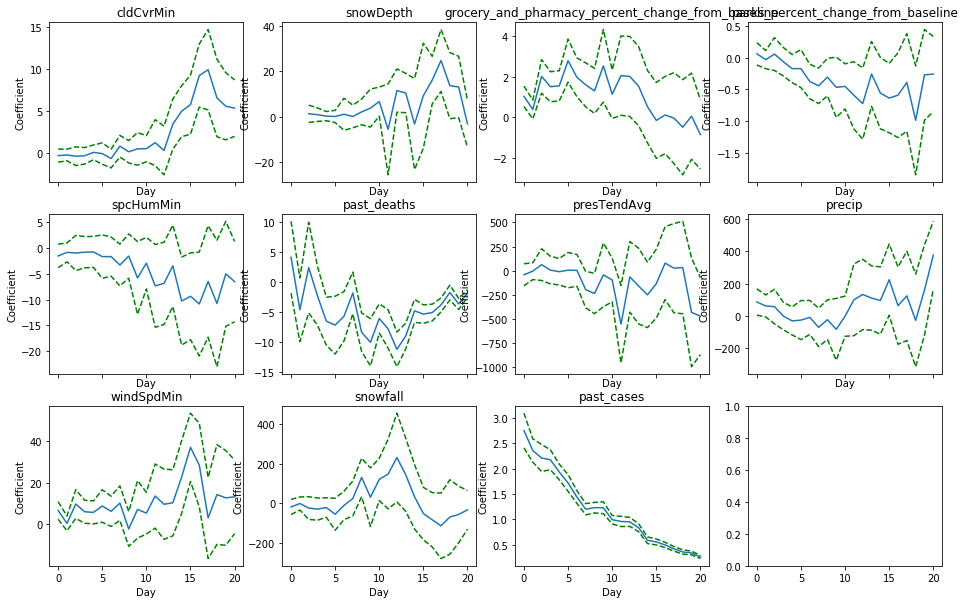

In [5]:
# variable coefficients
y = 'cases'
tmp_output_df = output_df[output_df['outcome_name'] == y]
n_variables = len(set(tmp_output_df['names']))
fig, axes = plt.subplots(int(np.ceil(n_variables / 4)), 4, figsize=(16, 10), sharex='all')

i = 0
for c in set(tmp_output_df['names']):
    tmp_input_df = tmp_output_df[tmp_output_df['names'] == c]
    axes[i // 4, i % 4].plot(tmp_input_df['start_date'], tmp_input_df['coefficients'])
    z = -0.862 + np.sqrt([0.743-2.404*np.log(tmp_input_df['p_value'])])
    se = np.abs(np.divide(tmp_input_df['coefficients'].values, z))
    upper = tmp_input_df['coefficients'].values+1.96*se[0]
    lower = tmp_input_df['coefficients'].values-1.96*se[0]
    axes[i // 4, i % 4].plot(tmp_input_df['start_date'], upper, 'g--')
    axes[i // 4, i % 4].plot(tmp_input_df['start_date'], lower, 'g--')
    
    axes[i // 4, i % 4].set_title(f'{c}')
    axes[i // 4, i % 4].set_ylabel('Coefficient')
    axes[i // 4, i % 4].set_xlabel('Day')
    i += 1

plt.show()

The above figure plots the coefficient for each variable as a function of the start day for each 7-day period. The idea is that, as the infection progresses, the factors that determine the speed at which the infection grows may be different.

For example, the effect of the mobility into grocery stores and pharmacies seems to go down over time. This may be because, as the infection progresses, people start engaging in protective behavior when they are in public, confined places. For example, they may start wearing masks and gloves, and grocery store staff may increase the frequency of cleaning the carts. This would reduce the risk of visiting a grocery store, so it would decrease the effect of that variable.

However, a limitation of this is that there is an important confounder: as we increase the day our 7-day window starts, some counties don't have enough data so they are dropped off. This makes comparisons between start days difficult, as they are made between different sets of counties.

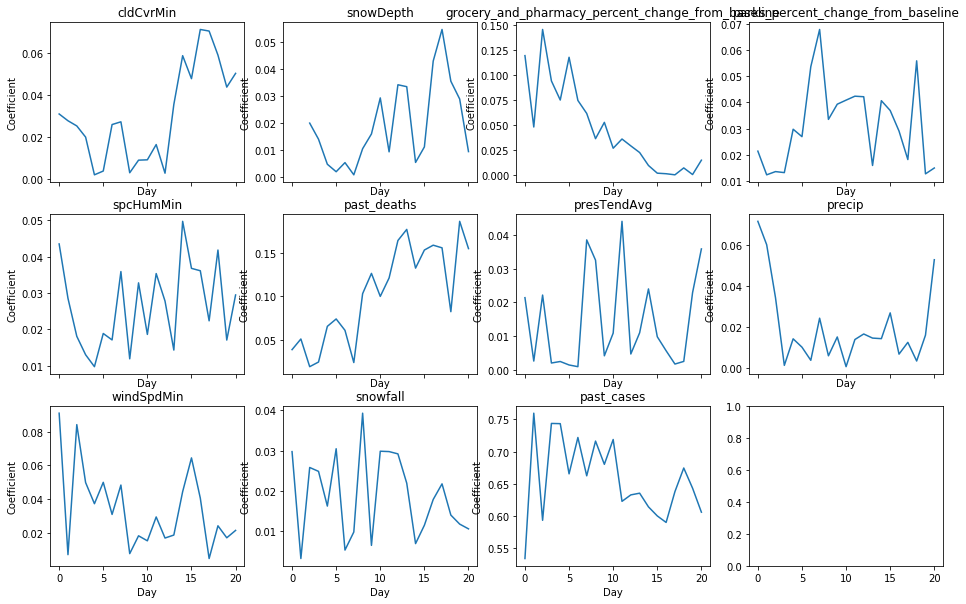

In [6]:
# variable importance
y = 'cases'
tmp_output_df = output_df[output_df['outcome_name'] == y]
n_variables = len(set(tmp_output_df['names']))
fig, axes = plt.subplots(int(np.ceil(n_variables / 4)), 4, figsize=(16, 10), sharex='all')

i = 0
for c in set(tmp_output_df['names']):
    tmp_input_df = tmp_output_df[tmp_output_df['names'] == c]
    axes[i // 4, i % 4].plot(tmp_input_df['start_date'],
                             tmp_input_df['percentage'])
    axes[i // 4, i % 4].set_title(f'{c}')
    axes[i // 4, i % 4].set_ylabel('Variable importance')
    axes[i // 4, i % 4].set_xlabel('Day')
    i += 1

plt.show()

This figure plots the relative importance of each variable by day. Because each model is calculated for each start day (the x axis on the graphs), the relative importance for all variables add up to 1 for each start day.

We can see that some variables change in importance as the start date changes. For example, for these models predicting the increase in the number of cases, we can see that the variable with the most importance is past_cases, with the importance between 0.55 and 0.75. The number of past deaths has lower importance in the early days, and more importance in the late days. 
We can also see that overall, the third variable in importance is the change in mobility for grocery and pharmacy, and that one is more important in the early days compared to the later days.

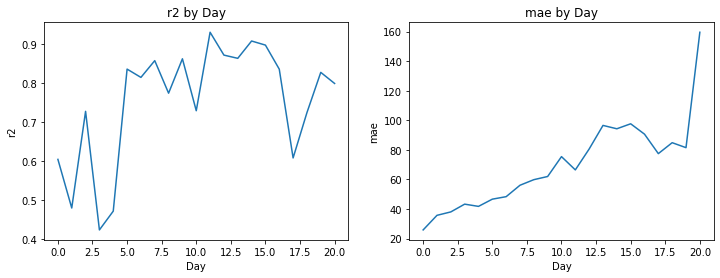

In [7]:
# performance plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
i = 0
for metric in ['r2', 'mae']:
    performance_df = output_df[['start_date', 'r2', 'mae', 'outcome_name']].drop_duplicates()
    tmp_performance_df = performance_df[performance_df['outcome_name'] == y]
    axes[i].plot(tmp_performance_df['start_date'], tmp_performance_df[metric])
    axes[i].set_title(f'{metric} by Day')
    axes[i].set_xlabel('Day')
    axes[i].set_ylabel(metric)
    i += 1

Here we plot the R-squared and the mean absolute error as a function of the day we start the 7-day interval.

For the R-squared, we see a noisy increase as a function of start day. This probably reflects that at the start, the number of cases is very low, so it is harder to predict the increase (the law of large numbers doesn't apply as much and random effects play a bigger role). As we progress in teh infection, the total number of cases increases (as we saw in our exploratory data analysis), and it becomes more predictable. The decrease at the end probably reflects that the number of counties for which we have data after day 15 or so is smaller.

For the MAE, we see an expected increase in the MAE. Because we are looking at the absolute error, this number is expected to go up as the overall number of cases goes up. In the early days, the number of cases is low (in the two digits up to a few hundred cases), so even an error of 40% is not that much. In the late days, as the number of cases goes into the thousands, even though the predictions get proportionately more accurate (more accurate as a percentage), the absolute error is greater.

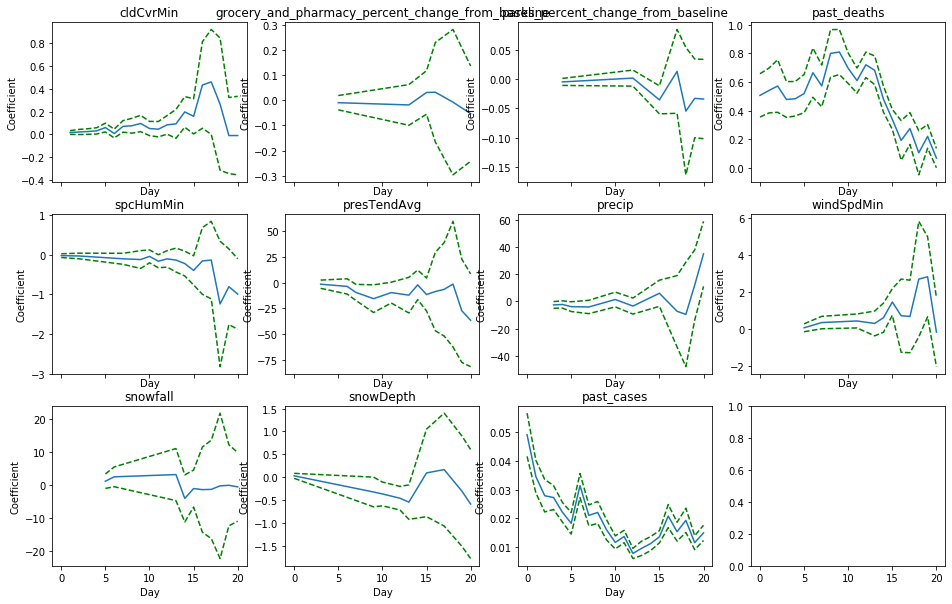

In [8]:
# variable coefficients
y = 'deaths'
tmp_output_df = output_df[output_df['outcome_name'] == y]
n_variables = len(set(tmp_output_df['names']))
fig, axes = plt.subplots(int(np.ceil(n_variables / 4)), 4, figsize=(16, 10), sharex='all')

i = 0
for c in set(tmp_output_df['names']):
    tmp_input_df = tmp_output_df[tmp_output_df['names'] == c]
    axes[i // 4, i % 4].plot(tmp_input_df['start_date'], tmp_input_df['coefficients'])
    z = -0.862 + np.sqrt([0.743-2.404*np.log(tmp_input_df['p_value'])])
    se = np.abs(np.divide(tmp_input_df['coefficients'].values, z))
    upper = tmp_input_df['coefficients'].values+1.96*se[0]
    lower = tmp_input_df['coefficients'].values-1.96*se[0]
    axes[i // 4, i % 4].plot(tmp_input_df['start_date'], upper, 'g--')
    axes[i // 4, i % 4].plot(tmp_input_df['start_date'], lower, 'g--')
    
    axes[i // 4, i % 4].set_title(f'{c}')
    axes[i // 4, i % 4].set_ylabel('Coefficient')
    axes[i // 4, i % 4].set_xlabel('Day')
    i += 1

plt.show()

For deaths, we see some interesting trends in the coefficients for the different variables. For example, we can see that in the early days, the number of past cases is a more important predictor compare to the late days. This is not surprising since early on, the number of cases is probably a relatively accurate estimate, whereas later on, the number of confirmed cases is more affected by the testing capacity of the county.

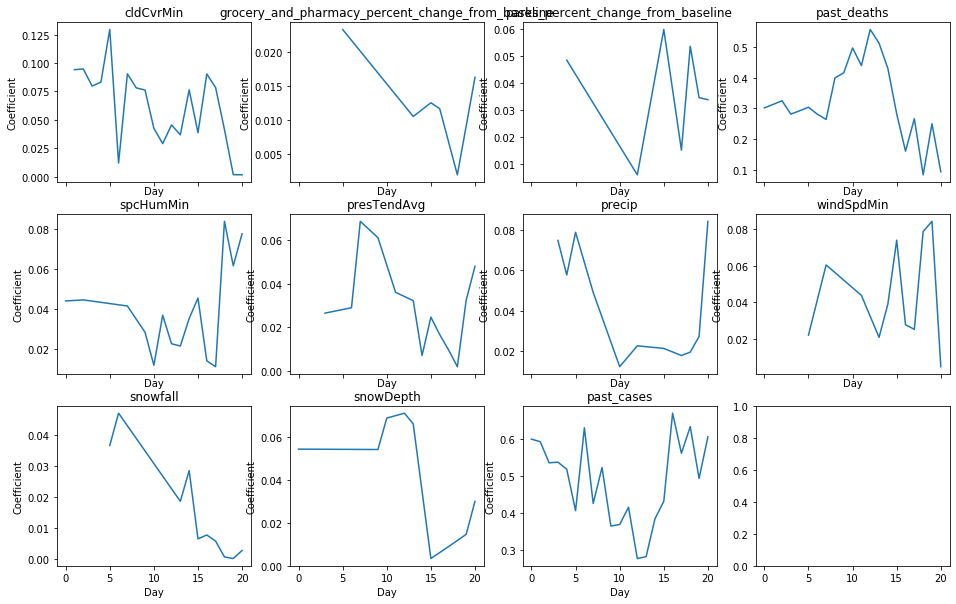

In [9]:
# variable importance
y = 'deaths'
tmp_output_df = output_df[output_df['outcome_name'] == y]
n_variables = len(set(tmp_output_df['names']))
fig, axes = plt.subplots(int(np.ceil(n_variables / 4)), 4, figsize=(16, 10), sharex='all')

i = 0
for c in set(tmp_output_df['names']):
    tmp_input_df = tmp_output_df[tmp_output_df['names'] == c]
    axes[i // 4, i % 4].plot(tmp_input_df['start_date'],
                             tmp_input_df['percentage'])
    axes[i // 4, i % 4].set_title(f'{c}')
    axes[i // 4, i % 4].set_ylabel('Variable importance')
    axes[i // 4, i % 4].set_xlabel('Day')
    i += 1

plt.show()

Above are the plots for variable importance for the models looking at deaths. We can see that the main two variables in importance are the past number of deaths and the past number of cases. In the early and late days, the number of cases (and not so much the number of deaths) is a more important predictor of the number of deaths in the next 3 days. However, both variables are probably very correlated.


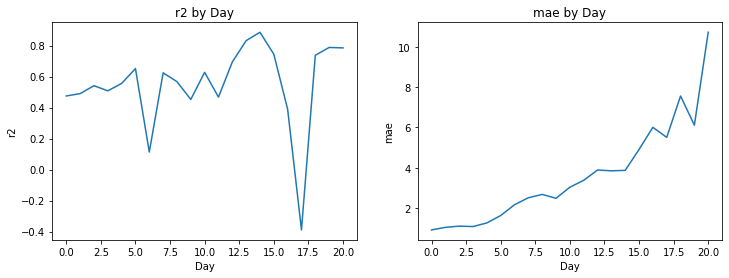

In [10]:
# performance plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
i = 0
for metric in ['r2', 'mae']:
    performance_df = output_df[['start_date', 'r2', 'mae', 'outcome_name']].drop_duplicates()
    tmp_performance_df = performance_df[performance_df['outcome_name'] == y]
    axes[i].plot(tmp_performance_df['start_date'], tmp_performance_df[metric])
    axes[i].set_title(f'{metric} by Day')
    axes[i].set_xlabel('Day')
    axes[i].set_ylabel(metric)
    i += 1

Here we see the R-squared and the Mean Absolute Error for the GLM model predicting the number of deaths.

As before, the MAE goes does with the scale of the prediction: in late days the absolute number of events increases, so the MAE increases as well.

The R-squared is harder to interpret, but overall it's lower for early days than for late days.